In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
C = torch.randn((27, 2))

In [13]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [16]:
h

tensor([[-0.4651,  0.1297,  1.0000,  ...,  0.9994, -0.9987, -1.0000],
        [-0.1797,  0.9843,  0.9933,  ...,  0.9987, -0.9988, -1.0000],
        [ 0.3830,  0.9767,  0.7048,  ...,  0.9971, -0.4132, -1.0000],
        ...,
        [ 0.5669, -0.1956, -0.7543,  ..., -0.3461,  0.6369, -0.6322],
        [ 0.5597,  0.9493, -0.9810,  ..., -0.3252, -0.8675, -0.8780],
        [ 0.4321,  0.7627,  0.4209,  ..., -0.0487,  0.0930, -0.7002]])

In [17]:
h.shape

torch.Size([228146, 100])

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2

In [21]:
logits.shape

torch.Size([228146, 27])

In [22]:
counts = logits.exp()

In [23]:
prob = counts / counts.sum(1, keepdims=True)

In [24]:
prob.shape

torch.Size([228146, 27])

In [26]:
loss = -prob[torch.arange(32), Y[32]].log().mean()
loss

tensor(14.9300)

In [27]:
# ------------ now made respectable :) ---------------

In [28]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [100]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.rand((27, 10), generator=g)
W1 = torch.rand((30, 200), generator=g)
b1 = torch.rand(200, generator=g)
W2 = torch.rand((200, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [30]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [54]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [101]:
lri = []
lossi = []
stepi = []

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

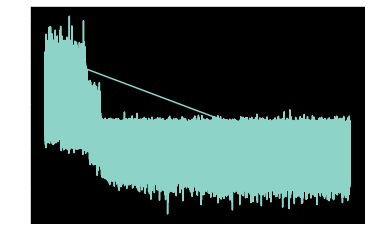

In [98]:
plt.plot(stepi, lossi)

In [99]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.8280, grad_fn=<NllLossBackward0>)

In [95]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1170, grad_fn=<NllLossBackward0>)

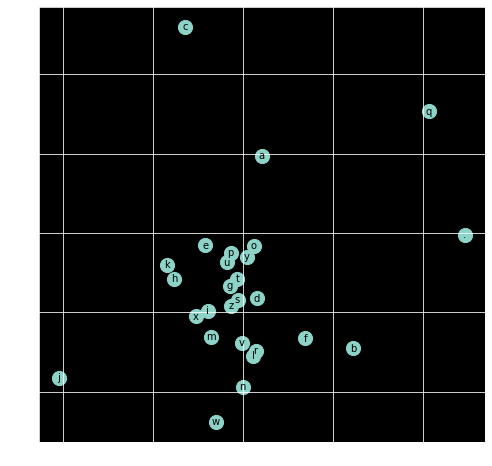

In [48]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='black')
plt.grid('minor')

# C is in 10 dimensions. Need it to be in 2d for the visualization below to be meaningful.

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [50]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [51]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpahxatolle.
khi.
miliathtyn.
kansen.
jazonen.
delynn.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
evin.
quinthanoi.
emi.
adbrion.
elon.
jaryni.
jaceenitraylen.
edi.
abetteley.


In [ ]:
# - E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
#   Just train longer, or increase learning rate
# - E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [73]:
import math
-math.log(1/27) # uniform distribution expected loss

# change the initialization of W2 and b2 to be uniform (rand instead of randn)
# loss changed from 26 to 6.4

3.295836866004329

In [103]:
test = torch.rand((27, 10), generator=g)
test

tensor([[4.5638e-02, 8.1052e-01, 7.7975e-01, 7.2373e-01, 9.8029e-01, 7.1550e-01,
         6.6397e-01, 2.2760e-01, 9.1630e-04, 8.2566e-01],
        [1.2033e-01, 9.9081e-01, 5.3056e-01, 9.2277e-01, 7.7487e-01, 1.6358e-01,
         1.8947e-01, 6.1463e-01, 8.6445e-01, 8.6702e-01],
        [2.3535e-01, 4.8720e-01, 9.7103e-02, 5.8668e-01, 7.6454e-01, 4.4998e-01,
         5.9904e-01, 2.8539e-01, 8.0303e-01, 3.0957e-01],
        [8.5648e-01, 6.6244e-01, 5.8040e-01, 8.6573e-01, 7.9071e-01, 1.2165e-01,
         9.3841e-01, 4.9714e-01, 3.3547e-01, 7.2875e-01],
        [4.9946e-01, 9.4354e-01, 8.2928e-02, 1.3904e-01, 4.8609e-01, 1.1222e-01,
         1.0718e-01, 7.3100e-01, 4.8992e-01, 9.7854e-01],
        [6.0040e-01, 9.0129e-01, 2.6735e-01, 8.5546e-01, 4.9420e-01, 8.2827e-02,
         2.3424e-01, 3.2498e-01, 9.9791e-01, 5.1748e-01],
        [8.6770e-01, 2.0944e-01, 5.6272e-01, 8.4832e-01, 5.8061e-01, 9.7985e-01,
         6.3236e-01, 5.3293e-01, 3.3808e-01, 7.8474e-01],
        [5.8395e-01, 2.9844